![title.png](images/ML_08_title.png)

# Agenda

### 1. ROC and AUC
### 2. Cross validation and k-fold
### 3. Grid search of hyperparameters
### 4. Gradient boosting intuition
### 5. Catboost: ordered target encoding
### 6. Catboost: building trees
### 7. Workshop

## 1. ML fundamentals: ROC and AUC

**Theory:**

The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (TPR) vs. the False Positive Rate (FPR) for different classification thresholds.
The Area Under the Curve (AUC) is given by:

$$\text{TPR} = \frac{TP}{TP + FN}$$  
$$\text{FPR} = \frac{FP}{FP + TN}$$  
$$\text{AUC} = \int_0^1 TPR(FPR) \, dFPR$$


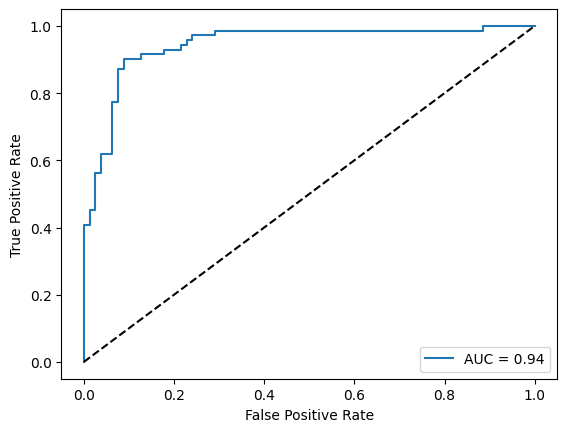

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=500, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:, 1] # attention here!
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Practical application:** ROC and AUC are widely used to evaluate binary classifiers, especially when class imbalance exists.

## 2. ML fundamentals: cross validation and k-fold

**Theory:**

Cross-validation splits the dataset into $k$ folds. Each fold is used once as a validation set while the remaining $k-1$ folds form the training set.
The $k$-fold CV estimate is:
$$CV_k = \frac{1}{k} \sum_{i=1}^{k} M_i$$
where $M_i$ is the performance metric for fold $i$.

![title.png](images/kfold.png)

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

iris = load_iris()
X, y = iris.data, iris.target
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(LogisticRegression(max_iter=200), X, y, cv=kf)
print('Scores per fold:', scores)
print('Mean score:', np.mean(scores))

Scores per fold: [1.         1.         0.93333333 0.96666667 0.96666667]
Mean score: 0.9733333333333334


**Practical application:** K-fold cross-validation is used to obtain a more reliable estimate of model performance and reduce overfitting risk.

## 3. ML fundamentals: grid search of hyperparameters

**Theory:**

Grid search tests all possible combinations of given hyperparameters and selects the one yielding the best performance.
Formally, it searches:
$$ \arg\max_{\theta \in \Theta} M(\theta) $$
where $M$ is the performance metric and $\Theta$ is the parameter grid.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
X, y = make_classification(n_samples=200, n_features=5, random_state=42)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, cv=3)
grid.fit(X, y)
print('Best params:', grid.best_params_)
print('Best score:', grid.best_score_)

Best params: {'C': 1, 'kernel': 'rbf'}
Best score: 0.870119101462385


**Practical application:** Grid search is useful for tuning hyperparameters to maximize model performance. Also check out Bayesian search

## 4. Gradient boosting intuition

**Theory:**

Gradient boosting builds an additive model by sequentially fitting weak learners to the residual errors of prior models.
The update at iteration $m$ is:
$$F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$$
where $\nu$ is the learning rate and $h_m$ is the weak learner.

### Gradient Boosting Algorithm — Step-by-Step Explanation with Tables

Consider a simple regression problem with the following dataset:

| Row | Feature $x$ | Target $y$ |
|------|---------------|--------------|
| 1    | 1             | 4            |
| 2    | 2             | 5            |
| 3    | 3             | 7            |
| 4    | 4             | 10           |

---

#### Step 1 — Initialization

- Start with a constant prediction, usually the mean of the target values:

$$
F_0 = \frac{4 + 5 + 7 + 10}{4} = 6.5
$$

| Row | Target $y$ | Initial Prediction $F_0$ | Residual $r_1 = y - F_0$ |
|------|--------------|----------------------------|-----------------------------|
| 1    | 4            | 6.5                        | $4 - 6.5 = -2.5$          |
| 2    | 5            | 6.5                        | $5 - 6.5 = -1.5$          |
| 3    | 7            | 6.5                        | $7 - 6.5 = 0.5$           |
| 4    | 10           | 6.5                        | $10 - 6.5 = 3.5$          |

---

#### Step 2 — Fit the first weak learner (tree) on residuals

- Fit a simple regression tree (e.g., depth 1 or 2) to predict residuals $r_1$.

| Row | Feature $x$ | Residual $r_1$ | Leaf assignment (split $x < 2.5$) |
|------|---------------|------------------|-------------------------------------|
| 1    | 1             | -2.5             | Left leaf                          |
| 2    | 2             | -1.5             | Left leaf                          |
| 3    | 3             | 0.5              | Right leaf                         |
| 4    | 4             | 3.5              | Right leaf                         |

- Compute leaf values as average residuals:

| Leaf       | Residuals         | Leaf value (average residual) |
|------------|-------------------|-------------------------------|
| Left leaf  | -2.5, -1.5        | $\frac{-2.5 + (-1.5)}{2} = -2.0$   |
| Right leaf | 0.5, 3.5          | $\frac{0.5 + 3.5}{2} = 2.0$         |

---

#### Step 3 — Update predictions

- Update predictions by adding scaled leaf values multiplied by learning rate $\nu = 0.1$:

$$
F_1 = F_0 + \nu \times h_1(x)
$$

| Row | Previous Prediction $F_0$ | Leaf Value | Update $\nu \times \text{Leaf Value}$ | New Prediction $F_1$       |
|------|-----------------------------|------------|------------------------------------------|------------------------------|
| 1    | 6.5                         | -2.0       | $0.1 \times -2.0 = -0.2$              | $6.5 - 0.2 = 6.3$           |
| 2    | 6.5                         | -2.0       | -0.2                                    | 6.3                          |
| 3    | 6.5                         | 2.0        | $0.1 \times 2.0 = 0.2$                | $6.5 + 0.2 = 6.7$           |
| 4    | 6.5                         | 2.0        | 0.2                                     | 6.7                          |

---

#### Step 4 — Compute new residuals

$$
r_2 = y - F_1
$$

| Row | Target $y$ | Prediction $F_1$ | Residual $r_2 = y - F_1$ |
|------|--------------|--------------------|-----------------------------|
| 1    | 4            | 6.3                | $-2.3$                    |
| 2    | 5            | 6.3                | $-1.3$                    |
| 3    | 7            | 6.7                | $0.3$                     |
| 4    | 10           | 6.7                | $3.3$                     |

---

#### Step 5 — Fit the second weak learner on new residuals

- Fit another tree to predict residuals $r_2$ (splitting $x < 3.5$):

| Row | Feature $x$ | Residual $r_2$ | Leaf assignment |
|------|---------------|------------------|-----------------|
| 1    | 1             | -2.3             | Left leaf       |
| 2    | 2             | -1.3             | Left leaf       |
| 3    | 3             | 0.3              | Left leaf       |
| 4    | 4             | 3.3              | Right leaf      |

- Compute leaf values:

| Leaf       | Residuals           | Leaf Value (average)     |
|------------|---------------------|-------------------------|
| Left leaf  | -2.3, -1.3, 0.3     | $\frac{-2.3 -1.3 + 0.3}{3} = -1.1$ |
| Right leaf | 3.3                 | 3.3                     |

---

#### Step 6 — Update predictions again

| Row | Previous Prediction $F_1$ | Leaf Value | Update $\nu \times \text{Leaf Value}$ | New Prediction $F_2$       |
|------|-----------------------------|------------|------------------------------------------|------------------------------|
| 1    | 6.3                         | -1.1       | $-0.11$                               | $6.3 - 0.11 = 6.19$         |
| 2    | 6.3                         | -1.1       | -0.11                                  | 6.19                         |
| 3    | 6.7                         | -1.1       | -0.11                                  | 6.59                         |
| 4    | 6.7                         | 3.3        | 0.33                                   | 7.03                         |

---

#### Step 7 — Repeat until convergence or stopping criteria

- Continue fitting new trees on residuals and updating predictions until performance is satisfactory or max iterations reached.

---

#### Summary table of each iteration

| Iteration | Action                              | Outcome                          |
|-----------|-----------------------------------|---------------------------------|
| 0         | Initialize $F_0$                | Constant prediction (mean target)|
| 1         | Fit tree on residuals $r_1$    | Learn to correct initial errors  |
| 2         | Update predictions to $F_1$    | Improved predictions             |
| 3         | Calculate new residuals $r_2$  | New errors to correct            |
| 4         | Fit next tree on residuals $r_2$| Further refine model            |
| ...       | Repeat                           | Model gradually improves         |

---

This table-based stepwise view helps understand the mechanics behind gradient boosting — iteratively learning and correcting residual errors with weak learners (trees).


## Catboost

1. **Random Permutation of Data**  
   The training data is randomly shuffled to create a specific order. This order is essential to prevent target leakage during encoding.

2. **Ordered Target Encoding of Categorical Features**  
   For each categorical feature, CatBoost computes the target encoding **on-the-fly** for each example, using only the target values from examples that come *before* it in the shuffled order.  
   This means when encoding example $i$, only data from examples $1, 2, \ldots, i-1$ is used.


#### Ordered Target Encoding Example (Step-by-Step)

Suppose we have the following ordered data:

| Row | Category | Target (y) |
|------|----------|------------|
| 1    | A        | 1          |
| 2    | B        | 0          |
| 3    | A        | 0          |
| 4    | B        | 1          |
| 5    | A        | 1          |

---

### Calculating ordered target encoding for each row:

We use the formula:

$$
\text{encoding}_i = \frac{\sum_{j < i,\, category_j = category_i} y_j + a \cdot P}{N_i + a}
$$

where:  
- $N_i$ = number of previous rows with the same category  
- $a$ = smoothing parameter (e.g., 1)  
- $P$ = global mean target = $\frac{1+0+0+1+1}{5} = 0.6$

---

| Row | Category | Target | Previous targets (same category) | Encoding Calculation                                    | Encoding |
|-------|----------|--------|----------------------------------|-------------------------------------------------------|----------|
| 1     | A        | 1      | None                             | $\frac{0 + 1 \times 0.6}{0 + 1} = 0.6$              | 0.6      |
| 2     | B        | 0      | None                             | $\frac{0 + 1 \times 0.6}{0 + 1} = 0.6$              | 0.6      |
| 3     | A        | 0      | Row 1 target = 1                 | $\frac{1 + 1 \times 0.6}{1 + 1} = \frac{1.6}{2} = 0.8$| 0.8      |
| 4     | B        | 1      | Row 2 target = 0                 | $\frac{0 + 1 \times 0.6}{1 + 1} = \frac{0.6}{2} = 0.3$| 0.3      |
| 5     | A        | 1      | Rows 1,3 targets = 1,0          | $\frac{1 + 0 + 1 \times 0.6}{2 + 1} = \frac{1.6}{3} \approx 0.53$ | 0.53     |

---

### Explanation:

- For **row 1**, no previous examples with category "A", so encoding is just the prior \(P=0.6\) weighted by smoothing.  
- For **row 3**, previous row with "A" is row 1 with target 1, so encoding is average of \([1]\) plus smoothing.  
- For **row 5**, previous rows with "A" are rows 1 and 3 with targets \([1,0]\), so encoding is their average plus smoothing.  
- Smoothing stabilizes the encoding especially for categories with few prior examples.

---

This approach prevents target leakage by using only **past information** when encoding each example.


4. **Iterative Tree Building**  
   Trees are built one at a time. For each new tree:  
   - Use the ordered target encoded features.  
   - Fit the tree to the current residuals (pseudo-residuals) based on the model so far.

### CatBoost Iterative Tree-Building — Step-by-Step Intuition

Imagine we want to train a CatBoost model on a small dataset. The training proceeds in **iterations**, where each iteration builds one tree to improve the model by correcting previous errors.

---

#### Dataset (simplified)

| Row | Features (numeric + encoded categorical) | Target (y) |
|------|------------------------------------------|------------|
| 1    | [1.5, 0.6]                               | 1          |
| 2    | [2.3, 0.4]                               | 0          |
| 3    | [1.1, 0.8]                               | 1          |
| 4    | [3.0, 0.2]                               | 0          |

---

#### Step 1 — Initialization

- Start with a constant prediction, usually the log-odds of the positive class (or mean target for regression).

| Row | Initial Prediction $F_0$ | Residual (pseudo-residual) $r_1 = y - \hat{y}$ |
|------|----------------------------|--------------------------------------------------|
| 1    | 0.4                        | $1 - 0.4 = 0.6$                              |
| 2    | 0.4                        | $0 - 0.4 = -0.4$                               |
| 3    | 0.4                        | $1 - 0.4 = 0.6$                                |
| 4    | 0.4                        | $0 - 0.4 = -0.4$                               |

---

#### Step 2 — Build the first tree on residuals

- Fit a small decision tree (e.g., max depth 1 or 2) to predict residuals $r_1$.

##### Symmetric vs asymmetric trees
- In **classic asymmetric trees** (used by many decision tree algorithms):
  - Each node **independently chooses** the best feature and threshold to split on.
  - For example:
    - The root node might split on feature A < 1.5.
    - The left child node might split on feature B < 3.0.
    - The right child node might split on feature C < 2.0.
  - This creates an **irregular and potentially unbalanced** tree structure.

- In **symmetric (oblivious) trees** (used by CatBoost):
  - All nodes at the **same depth level** use the **same feature and threshold** to split.
  - For example:
    - At depth 1, **every node** splits on feature A < 1.5.
    - At depth 2, **every node** splits on feature B < 3.0.
  - This produces a **perfectly balanced and symmetric** tree.

---

##### Visual example

| Classic Asymmetric Tree              | Symmetric (Oblivious) Tree            |
|------------------------------------|-------------------------------------|
| Root splits on feature A < 1.5     | Root splits on feature A < 1.5      |
| Left child splits on feature B < 3 | Left child splits on feature B < 3  |
| Right child splits on feature C < 2| Right child splits on feature B < 3 |
| Children split on different features and thresholds | All nodes on depth 2 split on feature B < 3 |

---

##### Why is symmetric splitting important?

- **Faster prediction:** Balanced trees allow simpler and more parallelizable prediction logic.
- **Reduced overfitting:** Restricting splits limits model complexity.
- **Efficient implementation:** Enables optimized storage and computation.

---

##### How this fits in the CatBoost example

- When the example shows a split on feature 1 at threshold 2.0, symmetric trees mean:
  - **All nodes at that level split on feature 1 < 2.0**, not just one node.
  - This results in a balanced binary tree where every path is defined by the same set of splits applied consistently.

- In this simplified example, the tree splits on **feature 1 at threshold 2.0**:

| Row | Feature 1 | Residual $r_1$ | Leaf assignment |
|------|-----------|------------------|-----------------|
| 1    | 1.5       | 0.6              | Left leaf       |
| 2    | 2.3       | -0.4             | Right leaf      |
| 3    | 1.1       | 0.6              | Left leaf       |
| 4    | 3.0       | -0.4             | Right leaf      |

- Compute leaf values as average residuals:

| Leaf       | Residuals        | Leaf Value (average) |
|------------|------------------|---------------------|
| Left leaf  | 0.6, 0.6         | 0.6                 |
| Right leaf | -0.4, -0.4       | -0.4                |

---

#### Step 3 — Update model predictions

- Add scaled leaf values to predictions (learning rate $\nu=0.1$):

| Row | Old Prediction $F_0$ | Leaf Value | Update $\nu \times \text{Leaf Value}$ | New Prediction $F_1$ |
|------|------------------------|------------|------------------------------------------|------------------------|
| 1    | 0.4                    | 0.6        | 0.06                                     | 0.46                   |
| 2    | 0.4                    | -0.4       | -0.04                                    | 0.36                   |
| 3    | 0.4                    | 0.6        | 0.06                                     | 0.46                   |
| 4    | 0.4                    | -0.4       | -0.04                                    | 0.36                   |

---

#### Step 4 — Compute new residuals

| Row | Target $y$ | Prediction $F_1$ | New Residual $r_2 = y - F_1$ |
|------|--------------|-------------------|---------------------------------|
| 1    | 1            | 0.46              | 0.54                            |
| 2    | 0            | 0.36              | -0.36                           |
| 3    | 1            | 0.46              | 0.54                            |
| 4    | 0            | 0.36              | -0.36                           |

---

#### Step 5 — Build second tree on new residuals and repeat

- Fit a new tree on residuals $r_2$ to further improve predictions.
- Continue this process iteratively.

---

#### Summary

| Iteration | Action                                  | Purpose                                      |
|-----------|-----------------------------------------|----------------------------------------------|
| 0         | Initialize with constant prediction     | Baseline prediction before learning           |
| 1         | Fit tree on residuals $r_1$           | Learn to correct errors of baseline            |
| 2         | Update predictions with tree output     | Improve model accuracy                          |
| 3         | Calculate new residuals $r_2$          | Identify remaining errors to fix                |
| 4         | Fit next tree on residuals $r_2$       | Continue refining the model                      |
| ...       | Repeat until stopping criteria           | Achieve desired performance                      |

---

This iterative refinement with small trees is how CatBoost (and other gradient boosting methods) gradually build a strong predictive model.

6. **Gradient Calculation and Model Update**  
   Update the ensemble model by adding the new tree scaled by the learning rate.

7. **Repeat for Many Iterations**  
   Repeat the encoding, residual computation, and tree building for the desired number of boosting rounds or until convergence.

8. **Prediction on New Data**  
   For new data, CatBoost uses techniques such as averaging over multiple permutations to generate stable ordered target encodings and make predictions.

---

## Why CatBoost’s approach is special

- Embeds **ordered target encoding** directly in training to avoid target leakage while leveraging target statistics.  
- Uses **symmetric trees** and efficient data structures for faster training and better generalization.  
- Handles missing data and categorical features without extra preprocessing.  
- Supports GPU acceleration for large datasets.

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict_proba(X_test)[:, 1]
auc_gbc = roc_auc_score(y_test, y_pred_gbc)

# CatBoost Classifier
cbc = CatBoostClassifier(random_state=42, verbose=0)
cbc.fit(X_train, y_train)
y_pred_cbc = cbc.predict_proba(X_test)[:, 1]
auc_cbc = roc_auc_score(y_test, y_pred_cbc)

print(f"GradientBoostingClassifier AUC: {auc_gbc:.4f}")
print(f"CatBoostClassifier AUC: {auc_cbc:.4f}")


GradientBoostingClassifier AUC: 0.9951
CatBoostClassifier AUC: 0.9968


### Which Algorithm Works Best in Kaggle Competitions and Competitive ML?

In the realm of Kaggle competitions and competitive machine learning, **Gradient Boosting** algorithms based on decision trees are among the most powerful and popular methods. Among them, **XGBoost**, **CatBoost**, and traditional **Gradient Boosting (like sklearn’s implementation)** are widely used.

- **XGBoost** has long been the de facto standard due to its speed, scalability, and strong performance on tabular data. It introduced important algorithmic and system optimizations (e.g., regularization, parallelization, approximate split finding) that made it a favorite among competitors.

- **CatBoost**, developed by Yandex, has gained popularity more recently for its state-of-the-art handling of categorical features without the need for extensive preprocessing, its **ordered boosting** technique that reduces target leakage, and its use of symmetric trees, which lead to faster training and better generalization in many scenarios.

- **Traditional Gradient Boosting** implementations (e.g., `sklearn.ensemble.GradientBoostingClassifier`) are simpler and easier to use but usually lag behind XGBoost and CatBoost in performance and efficiency, especially on large or complex datasets.

In general, **CatBoost and XGBoost tend to outperform traditional Gradient Boosting** in competitions. Between CatBoost and XGBoost, the best choice depends on dataset characteristics, feature types, and tuning efforts. CatBoost often excels when datasets contain many categorical variables or require reduced parameter tuning, while XGBoost is very flexible and highly optimized for numerical data.

---

### Algorithm Comparison Table

| Feature / Aspect                | Gradient Boosting (sklearn)      | XGBoost                          | CatBoost                         |
|-------------------------------|---------------------------------|---------------------------------|---------------------------------|
| **Handling of categorical features** | Requires manual encoding (one-hot, label encoding) | Requires encoding (though has some support) | Native categorical feature support without preprocessing |
| **Training speed & scalability**     | Moderate, slower on large data  | Fast, highly optimized (parallel & distributed) | Fast with GPU support, efficient due to symmetric trees |
| **Prediction speed**                  | Moderate                       | Fast                            | Very fast due to symmetric trees |
| **Overfitting control**               | Basic regularization options   | Advanced regularization (L1, L2) | Ordered boosting reduces target leakage and overfitting |
| **Ease of use**                      | Very easy, standard API        | More parameters, requires tuning | User-friendly, fewer hyperparameters to tune |
| **Handling of target leakage**       | No special measures            | No special measures             | Ordered boosting explicitly handles target leakage |
| **Popularity in competitions**       | Less common nowadays           | Very popular, widely used       | Increasing popularity, especially with categorical data |
| **Interpretability**                 | Good                          | Good                           | Good, with tools like SHAP integration |
| **GPU support**                     | Limited                       | Excellent                      | Excellent                       |

---

Overall, **CatBoost and XGBoost represent state-of-the-art gradient boosting algorithms widely preferred in competitive machine learning**, with CatBoost standing out for categorical data and ease of use, and XGBoost for raw speed and flexibility.

